In [1]:
#loading all the packages and modules needed for classification

import os
import cv2
import time
import math
import random

import data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

/home/tarun/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#define the path of train and test folder
train_path = 'Data/YE358311_Fender_apron'
test_path = 'Data/test'

In [3]:
#defined filter size and number of filter for three convolution layers, number of fully connected layers , number
# of channels, input image size, classes, batch size and validation proportion.

# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = os.listdir(train_path)
num_classes = len(classes)
print("num of classes:", num_classes)

# batch size
batch_size = 32

# validation split
validation_size = .3

early_stopping = None  # use None if you don't want to implement early stoping

num of classes: 2


In [4]:
#load train and test data from the help of data.py module
train_data = data.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_imgs, test_ids = data.load_test(test_path, img_size)

In [5]:
#print size of train and test set
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_imgs)))
print("- Validation-set:\t{}".format(len(train_data.valid.labels)))

Size of:
- Training-set:		173
- Test-set:		4
- Validation-set:	73


In [6]:
#plot few eg of train set to visualize the data
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

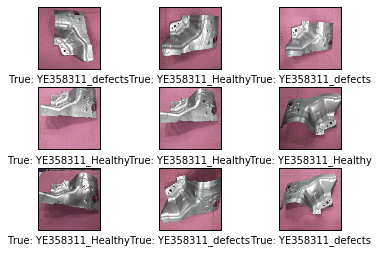

In [7]:
# Get some random images and their labels from the train set.
images, cls_true  = train_data.train.images, train_data.train.cls

# Plot the images and labels using function above.
plot_images(images=images, cls_true=cls_true)

In [8]:
#initialize weigts and bias with random values
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


In [9]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
#define the convolution layer architecture
def new_conv_layer(input,              # previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.\
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights or filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    return layer, weights

In [11]:
#define the flatten layer architecture
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    return layer_flat, num_features

In [12]:
#defined the fully connected layer architecture
def new_fc_layer(input,          # previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
#Placeholder variables serve as the input to the TensorFlow computational graph 
#that we may change each time we execute the graph.
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [14]:
#defining first conv layer
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 32) dtype=float32>

In [15]:
#defining second conv layer
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 32) dtype=float32>

In [16]:
#defining third conv layer
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

In [17]:
#defining flatten layer
layer_flat, num_features = flatten_layer(layer_conv3)
layer_flat
num_features

16384

In [18]:
#defining first fully connected layer 
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [19]:
#defining second fully connected layer 
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 2) dtype=float32>

In [20]:
#defining softmax layer to make the prediction
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [21]:
# To make the model better at classifying the input images, 
#we must somehow change the variables for all the network layers by cross_entropy and then
# take the average of all image's cross entropies 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

#used adam as optimizer as it is advance form of gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [22]:
#calculating accuracy and predictions with probabilities
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [23]:
#definind tensorflow session
session = tf.Session()
#The variables for weights and biases must be initialized before we start optimizing them
session.run(tf.initialize_all_variables())


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [24]:
#function to print the progress of training after each epochs
train_batch_size = batch_size
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))


In [25]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def train(num_iterations):
    # update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = train_data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = train_data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth] to [num examples, flattened image shape]
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(train_data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(train_data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    #if early stopping sets to true
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    end_time = time.time()
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))


In [26]:
#run the training with defined number of iterations
train(num_iterations=1000)

Epoch 1 --- Training Accuracy:  56.2%, Validation Accuracy:  50.0%, Validation Loss: 0.717
Epoch 2 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 0.778
Epoch 3 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 0.719
Epoch 4 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 0.705
Epoch 5 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 0.699
Epoch 6 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 0.728
Epoch 7 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 0.712
Epoch 8 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 0.718
Epoch 9 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 0.702
Epoch 10 --- Training Accuracy:  43.8%, Validation Accuracy:  43.8%, Validation Loss: 0.718
Epoch 11 --- Training Accuracy:  43.8%, Validation Accuracy:  50.0%, Validation Loss: 0.7

Epoch 91 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.260
Epoch 92 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 0.701
Epoch 93 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.265
Epoch 94 --- Training Accuracy: 100.0%, Validation Accuracy:  62.5%, Validation Loss: 0.727
Epoch 95 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.259
Epoch 96 --- Training Accuracy: 100.0%, Validation Accuracy:  71.9%, Validation Loss: 0.760
Epoch 97 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.265
Epoch 98 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.865
Epoch 99 --- Training Accuracy: 100.0%, Validation Accuracy:  84.4%, Validation Loss: 0.348
Epoch 100 --- Training Accuracy: 100.0%, Validation Accuracy:  78.1%, Validation Loss: 0.892
Epoch 101 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validatio

Epoch 180 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.321
Epoch 181 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.362
Epoch 182 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.330
Epoch 183 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.366
Epoch 184 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.338
Epoch 185 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.368
Epoch 186 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.347
Epoch 187 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.370
Epoch 188 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, Validation Loss: 1.356
Epoch 189 --- Training Accuracy: 100.0%, Validation Accuracy:  87.5%, Validation Loss: 0.373
Epoch 190 --- Training Accuracy: 100.0%, Validation Accuracy:  65.6%, 

In [27]:
#save the trained model state
saver = tf.train.Saver()
saver.save(session, 'Models/_model_v1')


'Models/_model_v1'

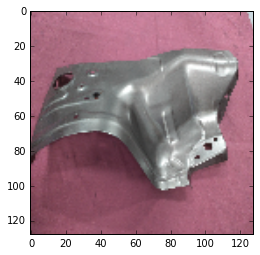

In [28]:
#load some test image and plot it
test_1 = cv2.imread('Data/test/IMG20180905151334.jpg')
test_1 = cv2.resize(test_1, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_test1 = plt.imshow(test_1.reshape(img_size, img_size, num_channels))

In [29]:
#run prediction on above test image
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[1, 0]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

print("Predicted class for test_cat: {}".format(sample_prediction(test_1)))

Predicted class for test_cat: YE358311_Healthy


In [30]:
#write prediction for all tes images in the .csv file
def test_predictions(img, ids):
    img = img.reshape(img.shape[0], img_size_flat)
    preds = session.run(y_pred, feed_dict={x: img})
    result = pd.DataFrame(preds, columns=classes)
    result.loc[:, 'id'] = pd.Series(ids, index=result.index)
    pred_file = 'JBM_predictions.csv'
    result.to_csv(pred_file, index=False)

#call the above function with pre loaded test data
test_predictions(test_imgs, test_ids)

In [31]:
#close tensor flow session creted above.
session.close()

In [32]:
#Thank you